# The Nearest Neighbors Classifier

In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

2023-07-04 11:02:23.446294: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-04 11:02:23.542731: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [37]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)  # Select the number of components you want to keep

X_train = pd.DataFrame(x_train.reshape((-1, 28*28)))

principal_components = pca.fit_transform(X_train)

df_train = pd.DataFrame(principal_components, columns=['PC1', 'PC2'])
df_train['digit'] = y_train

X_test = pd.DataFrame(x_test.reshape((-1, 28*28)))
pc_test = pca.transform(X_test)
df_test = pd.DataFrame(pc_test, columns=['PC1', 'PC2'])
df_test['digit'] = y_test

Now we select a sample of the objects belonging to digits 0, 1, and 2.

In [38]:
df_train = df_train[df_train.digit.isin({0, 1, 2})].sample(n=100, random_state=23)
df_test = df_test[df_test.digit.isin({0, 1, 2})]

And plot the digits in the projected space

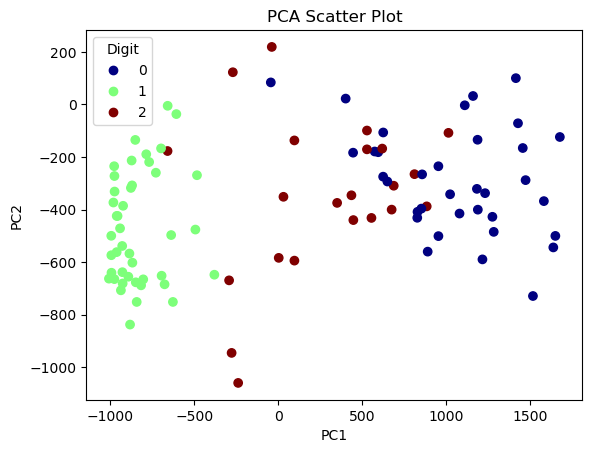

In [39]:
import matplotlib.pyplot as plt

scatter = plt.scatter(df_train['PC1'], df_train['PC2'], c=df_train['digit'], cmap="jet")
legend_elements = scatter.legend_elements()
labels = [str(digit) for digit in df_train['digit'].unique()]
plt.legend(handles=legend_elements[0], labels=labels, title='Digit')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA Scatter Plot')
plt.show()

Now, lets take a point in the test set and plot it together with the training objects

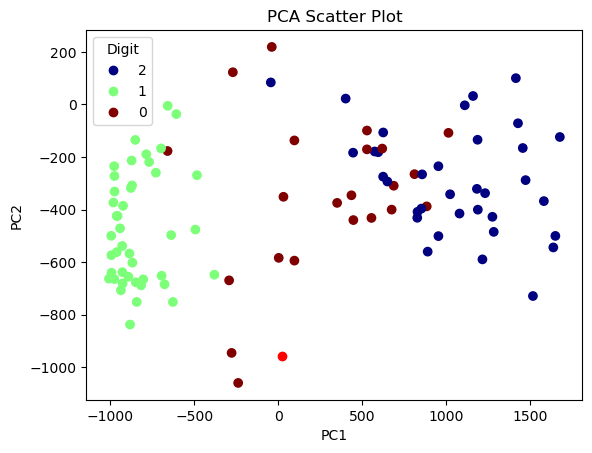

In [47]:
def plot_with_element(elements):
    scatter = plt.scatter(df_train['PC1'], df_train['PC2'], c=df_train['digit'], cmap="jet")
    legend_elements = scatter.legend_elements()
    labels = [str(digit) for digit in df_test['digit'].unique()]
    plt.legend(handles=legend_elements[0], labels=labels, title='Digit')

    for element in elements:
        plt.scatter(element.PC1, element.PC2, c='red')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title('PCA Scatter Plot')
    plt.show()

element = df_test.iloc[0]
plot_with_element([element])

To which class the red dot belongs?

One idea is to assign the object to the class of its closest object in the dataset

In [25]:
from scipy.spatial.distance import cdist

df_train_values = df_train[['PC1', 'PC2']].values

def get_nn(obj):
    point = np.array([[obj.PC1, obj.PC2]])
    distances = cdist(point, df_train_values, metric='euclidean')[0]
    idx_min = np.argmin(distances)
    return df_train.iloc[idx_min]

Now we can compare the digit of some object with the digit of its closest object

In [26]:
element = df_test.iloc[0]
print(element)
get_nn(element)

PC1       20.696803
PC2     -955.594512
digit      2.000000
Name: 1, dtype: float64


PC1      -238.610708
PC2     -1059.874014
digit       2.000000
Name: 31890, dtype: float64

So, the class of the closest object, the **nearest neighbor** is the same that the class of the object. Lets see another object:

In [45]:
element = df_test.iloc[1]
print(element)
get_nn(element)

PC1     -946.026807
PC2     -430.846531
digit      1.000000
Name: 2, dtype: float64


PC1     -955.856225
PC2     -424.382030
digit      1.000000
Name: 40884, dtype: float64

It is the same! So, it seems that the class of an object is probably the same the the class of its closest object. 

Lets test in how many object we get the same behavior:

In [46]:
count_total, count_correct = 0, 0
for idx in range(len(df_test)):
    element = df_test.iloc[idx]
    nn = get_nn(element)
    if nn.digit == element.digit:
        count_correct += 1
    count_total += 1
count_correct / count_total

0.811566571337782

Since more than 80% of the numbers has a nearest neighbor of its own class, we can use this property to create a classifier: **The nearest neighbor classifier**.

As we have seen there are objects where this property does not holds. Lets plot some of them.

In [50]:
wrong_elements = []
for idx in range(len(df_test)):
    element = df_test.iloc[idx]
    nn = get_nn(element)
    if nn.digit != element.digit:
        wrong_elements.append(element)

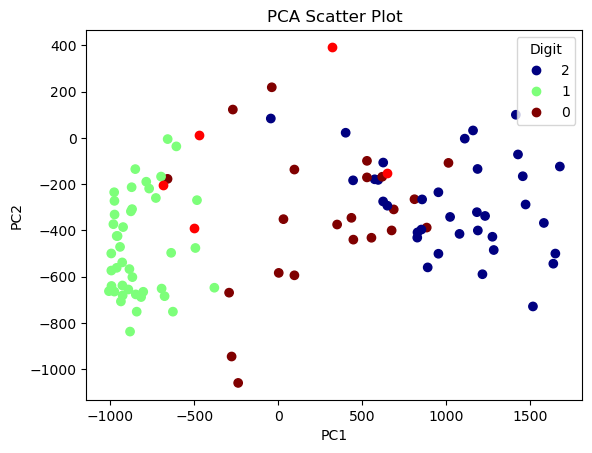

In [52]:
plot_with_element(wrong_elements[:5])

You can see here that the errors are mainly of two kind:
- objects in boundary locations between two classes
- objects close to outlayers

How can we solve this? Increase the numbers of neighbors to consider.

In [61]:
from sklearn.neighbors import NearestNeighbors

def get_k_nn(obj, k):
    knn = NearestNeighbors(n_neighbors=k)
    knn.fit(df_train_values)
    point = np.array([[obj.PC1, obj.PC2]])
    distances, indices = knn.kneighbors(point)
    nearest_points = df_train.iloc[indices[0]]
    return nearest_points

Lets take a look to other neighbors of the incorrectly classified objects we found before

In [66]:
print(wrong_elements[0])
get_k_nn(wrong_elements[0], 7)  

PC1     -499.948329
PC2     -391.634073
digit      2.000000
Name: 43, dtype: float64


,PC1,PC2,digit
57714,-492.992056,-476.109733,1
49499,-483.576065,-269.193154,1
11943,-637.140663,-497.015140,1
4865,-728.035629,-259.743626,1
30596,-658.578493,-177.137612,2
45532,-380.149707,-648.031068,1
10136,-697.249857,-167.142732,1


In [67]:
print(wrong_elements[2])
get_k_nn(wrong_elements[2], 7)  

PC1      646.581367
PC2     -151.295687
digit      0.000000
Name: 55, dtype: float64


,PC1,PC2,digit
325,618.251289,-167.816926,2
59605,624.087401,-106.532603,0
42865,594.164285,-181.637867,0
34051,573.391221,-178.905203,0
54978,527.443336,-170.720103,2
4047,623.678491,-274.760732,0
56264,527.507037,-99.106489,2


 If we consider more than one nearest neighbor, we can apply the **majority vote** to select the proper classification.

In [92]:
k = 3

count_total, count_correct = 0, 0
for idx in range(len(df_test)):
    count_total += 1
    element = df_test.iloc[idx]
    nn = get_k_nn(element, k)
    vote = nn.digit.value_counts().index.tolist()[0]
    if vote == element.digit:
        count_correct += 1

count_correct / count_total

0.8252303781379091

So, it works a little better than with k=1. 

The nearest neighbors classifier considering more than one neighbor is called K Nearest Neighbor classifier, or KNN.

Lets now introduce the scikit-learn code to train the KNN classifier.

In [99]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3)

knn.fit(df_train[['PC1', 'PC2']], df_train.digit)

KNeighborsClassifier(n_neighbors=3)

Note:
- the KNN classifier can be slower than other classifiers because of the huge amount of distances that need to be calculated for query object

In [102]:
from sklearn.metrics import accuracy_score
# Make predictions on the test set
y_pred = knn.predict(df_test[['PC1', 'PC2']])

# Evaluate the accuracy of the classifier
accuracy = accuracy_score(df_test.digit, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8233238004448681


Lets explore the influence of k in the accuracy.

In [116]:
accuracies = []
for k in range(1, 20, 2):
    knn = KNeighborsClassifier(n_neighbors=k)

    knn.fit(df_train[['PC1', 'PC2']], df_train.digit)
    y_pred = knn.predict(df_test[['PC1', 'PC2']])
    accuracy = accuracy_score(df_test.digit, y_pred)
    accuracies.append((k, accuracy))

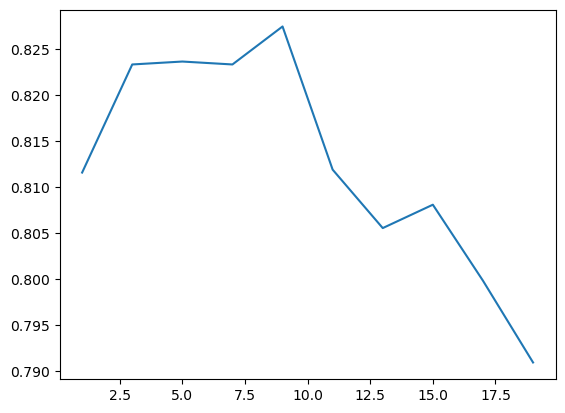

In [117]:
to_show = pd.DataFrame(accuracies, columns=['k', 'accuracy'])
plt.plot(to_show.k, to_show.accuracy)
plt.show()

Notes:
- The selection of the value of k have some influence in the quality of the result
- To select the best value for k you can use cross validation

## The course of dimensionality
The "curse of dimensionality" refers to the challenges and limitations that arise when working with high-dimensional data. It refers to the phenomenon where the increase in the number of dimensions in a dataset leads to various difficulties in data analysis:
- Increase the computational cost of running algorithms
- The available data becomes increasingly sparse
- Distance values between objects tends to be much more similar to each other

Lets see what happen by using 10 features in the training data

In [143]:
feature_count = 8

pca = PCA(n_components=feature_count)  # Select the number of components you want to keep

X_train = pd.DataFrame(x_train.reshape((-1, 28*28)))
principal_components = pca.fit_transform(X_train)
df_train = pd.DataFrame(principal_components, columns=[f'PC{n}' for n in range(feature_count)])
df_train['digit'] = y_train
X_test = pd.DataFrame(x_test.reshape((-1, 28*28)))
pc_test = pca.transform(X_test)
df_test = pd.DataFrame(pc_test, columns=[f'PC{n}' for n in range(feature_count)])
df_test['digit'] = y_test

df_train = df_train[df_train.digit.isin({0, 1, 2})].sample(n=100, random_state=23)
df_test = df_test[df_test.digit.isin({0, 1, 2})]

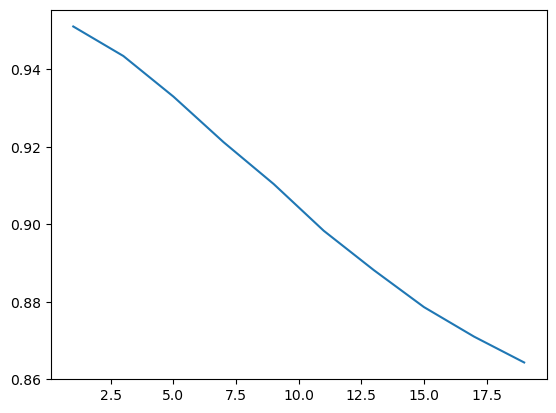

In [144]:
accuracies = []
for k in range(1, 20, 2):
    knn = KNeighborsClassifier(n_neighbors=k)

    knn.fit(df_train.iloc[:,:-1], df_train.digit)
    y_pred = knn.predict(df_test.iloc[:,:-1])
    accuracy = accuracy_score(df_test.digit, y_pred)
    accuracies.append((k, accuracy))
to_show = pd.DataFrame(accuracies, columns=['k', 'accuracy'])
plt.plot(to_show.k, to_show.accuracy)
plt.show()

Now, lets increase the number of features to 100.

In [151]:
accuracies = []
for feature_count in range(2, 110, 10):
    pca = PCA(n_components=feature_count)  # Select the number of components you want to keep

    X_train = pd.DataFrame(x_train.reshape((-1, 28*28)))
    principal_components = pca.fit_transform(X_train)
    df_train = pd.DataFrame(principal_components, columns=[f'PC{n}' for n in range(feature_count)])
    df_train['digit'] = y_train
    X_test = pd.DataFrame(x_test.reshape((-1, 28*28)))
    pc_test = pca.transform(X_test)
    df_test = pd.DataFrame(pc_test, columns=[f'PC{n}' for n in range(feature_count)])
    df_test['digit'] = y_test

    df_train = df_train[df_train.digit.isin({0, 1, 2})].sample(n=100, random_state=23)
    df_test = df_test[df_test.digit.isin({0, 1, 2})]
    
    knn = KNeighborsClassifier(n_neighbors=1)

    knn.fit(df_train.iloc[:,:-1], df_train.digit)
    y_pred = knn.predict(df_test.iloc[:,:-1])
    accuracy = accuracy_score(df_test.digit, y_pred)
    accuracies.append((feature_count, accuracy))

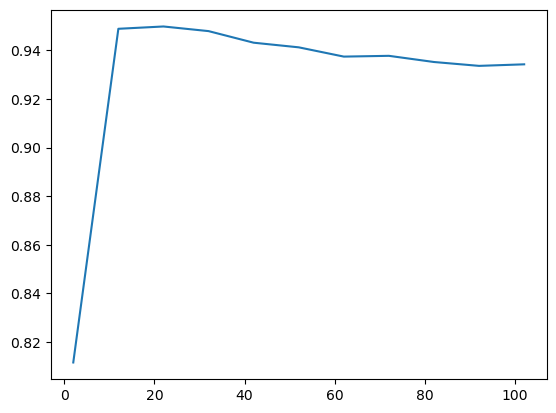

In [153]:
to_show = pd.DataFrame(accuracies, columns=['feature_count', 'accuracy'])
plt.plot(to_show.feature_count, to_show.accuracy)
plt.show()